In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
#data = pd.read_csv(r"E:\CDAC\Project\Pune.csv")
#from google.colab import drive
#drive.mount('/content/drive')
# Load the file from Google Drive
#data = pd.read_csv("/content/drive/MyDrive/Datasets - Colab/Pune.csv")
data=pd.read_csv('/kaggle/input/agartala-temp/Agartala_combined_data.csv')

In [3]:
#checking columns
data.columns

Index(['Date', 'T2M', 'T2MDEW', 'T2MWET', 'PS', 'PSC', 'WS2M', 'QV2M', 'RH2M',
       'PRECTOTCORR'],
      dtype='object')

In [4]:
#dropping unrequired features
data=data.drop(['T2MDEW', 'T2MWET', 'PS', 'PSC', 'WS2M', 'QV2M', 'RH2M', 'PRECTOTCORR'], axis=1)

In [5]:
# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d%H')
data.head()

,Date,T2M
0,2004-01-01 06:00:00,11.97
1,2004-01-01 07:00:00,12.95
2,2004-01-01 08:00:00,15.06
3,2004-01-01 09:00:00,19.23
4,2004-01-01 10:00:00,21.79


In [7]:
#changing index to date
data.index = data['Date']
data.head()

,Date,T2M
Date,,
2004-01-01 06:00:00,2004-01-01 06:00:00,11.97
2004-01-01 07:00:00,2004-01-01 07:00:00,12.95
2004-01-01 08:00:00,2004-01-01 08:00:00,15.06
2004-01-01 09:00:00,2004-01-01 09:00:00,19.23
2004-01-01 10:00:00,2004-01-01 10:00:00,21.79


In [8]:
data=data.sort_index()

In [40]:
data.head()

,Date,TEMP
Date,,
2004-01-01 06:00:00,2004-01-01 06:00:00,11.97
2004-01-01 07:00:00,2004-01-01 07:00:00,12.95
2004-01-01 08:00:00,2004-01-01 08:00:00,15.06
2004-01-01 09:00:00,2004-01-01 09:00:00,19.23
2004-01-01 10:00:00,2004-01-01 10:00:00,21.79


In [11]:
data.count()

Date    175320
T2M     175320
dtype: int64

In [12]:
#Renaming columns
data.rename(columns={'T2M': 'TEMP'}, inplace=True)

In [13]:
# Splitting data into train and test sets
train_data = data[:-120]  # Use all data except the last 48 hours for training
test_data = data[-120:]   # Use the last 48 hours for testing

In [14]:
# SARIMA model parameters
order = (1, 1, 1)  # ARIMA parameters (p, d, q)
seasonal_order = (1, 1, 1, 24)  # SARIMA parameters (P, D, Q, S)

In [15]:
check=train_data[:8760] #1 year data
test=train_data[8760:8808] #2 days = 48 hours

In [42]:
#to store RMSE after every year
rmse_record={}

In [43]:
# Fit SARIMA model
agartala_model = SARIMAX(check["TEMP"], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False, dates=check["Date"])
agartala_result = agartala_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36356D-01    |proj g|=  6.58034D-01

At iterate    5    f=  1.04477D-01    |proj g|=  1.05833D+00

At iterate   10    f=  7.33021D-02    |proj g|=  1.00310D-01

At iterate   15    f=  7.04334D-02    |proj g|=  1.78745D-03

At iterate   20    f=  7.04202D-02    |proj g|=  7.55521D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   7.555D-06   7.042D-02
  F =   7.0420153902889276E-002

CONVERG

In [44]:
# Forecast temperatures for the next 48 hours
forecast = agartala_result.get_forecast(steps=48)

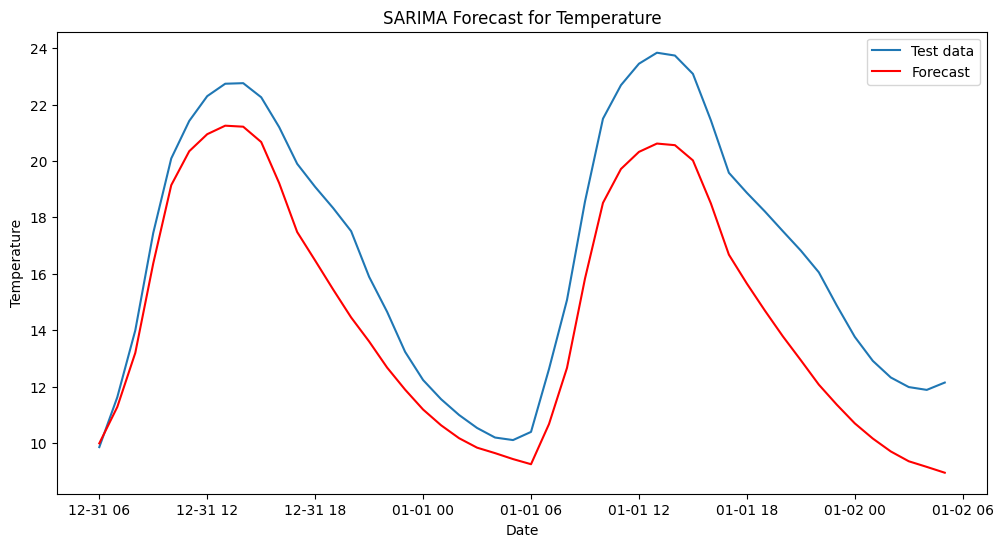

In [45]:
# Plot the predicted values along with the actual values
plt.figure(figsize=(12, 6))
#plt.plot(check.index, check["TEMP"], label='Train data')
plt.plot(test.index, test["TEMP"], label='Test data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
#plt.plot(forecast.index, forecast.predicted_mean, label='Forecast', color='red')
#plt.fill_between(forecast.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('SARIMA Forecast for Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [46]:
rmse = np.sqrt(mean_squared_error(test["TEMP"], forecast.predicted_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 2.4306795473143294


In [47]:
rmse_record[1]=rmse

In [22]:
#saving pickle file of model
#with open("/kaggle/working/agartala_model.pkl", 'wb') as f:
#    pickle.dump(agartala_result, f)

In [48]:
table=[8760*x for x in range(1, 21)]
#table

[8760,
 17520,
 26280,
 35040,
 43800,
 52560,
 61320,
 70080,
 78840,
 87600,
 96360,
 105120,
 113880,
 122640,
 131400,
 140160,
 148920,
 157680,
 166440,
 175200]

In [49]:
train_data.count()

Date    175200
TEMP    175200
dtype: int64

training now:  2


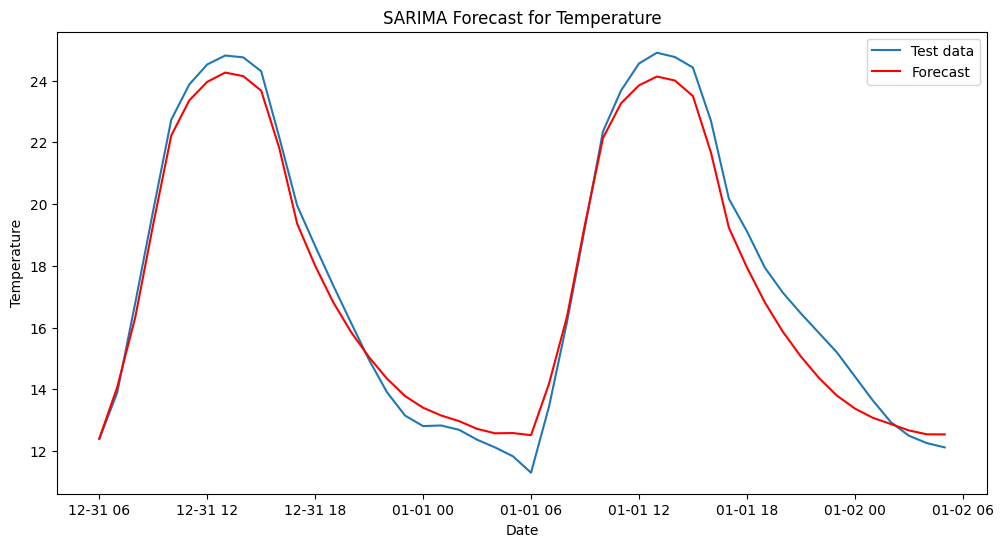

Root Mean Squared Error (RMSE): 0.7123344503488975
training now:  3


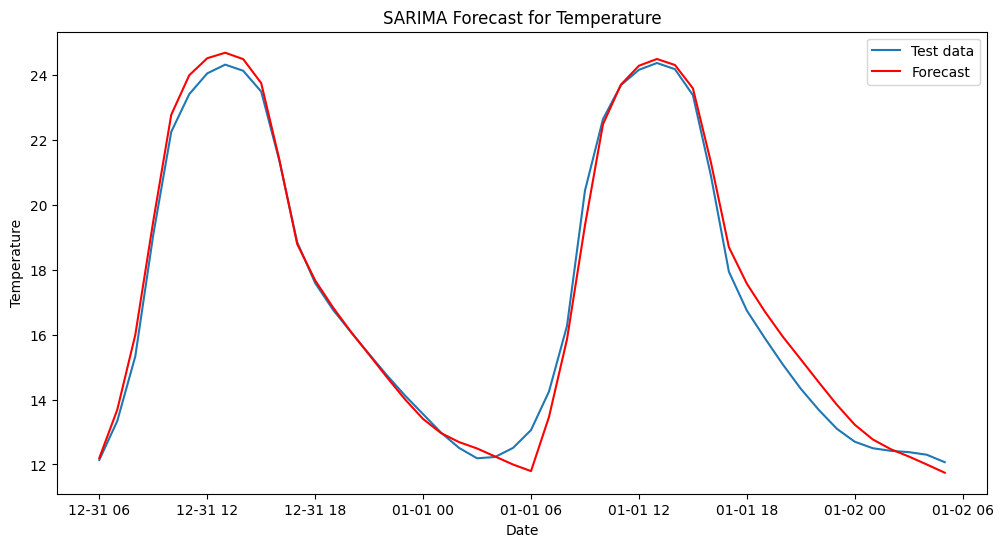

Root Mean Squared Error (RMSE): 0.48892623968637655
training now:  4


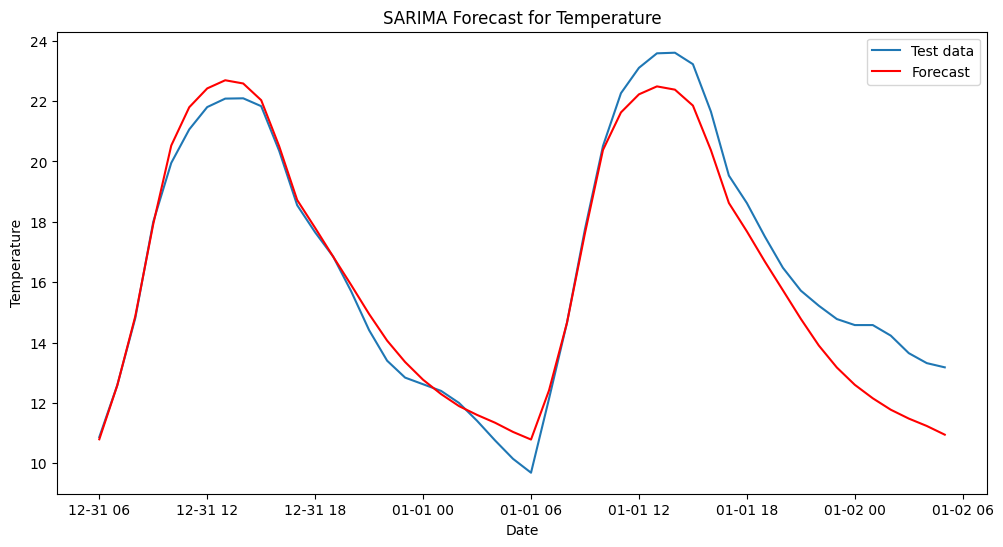

Root Mean Squared Error (RMSE): 1.0297014559185809
training now:  5


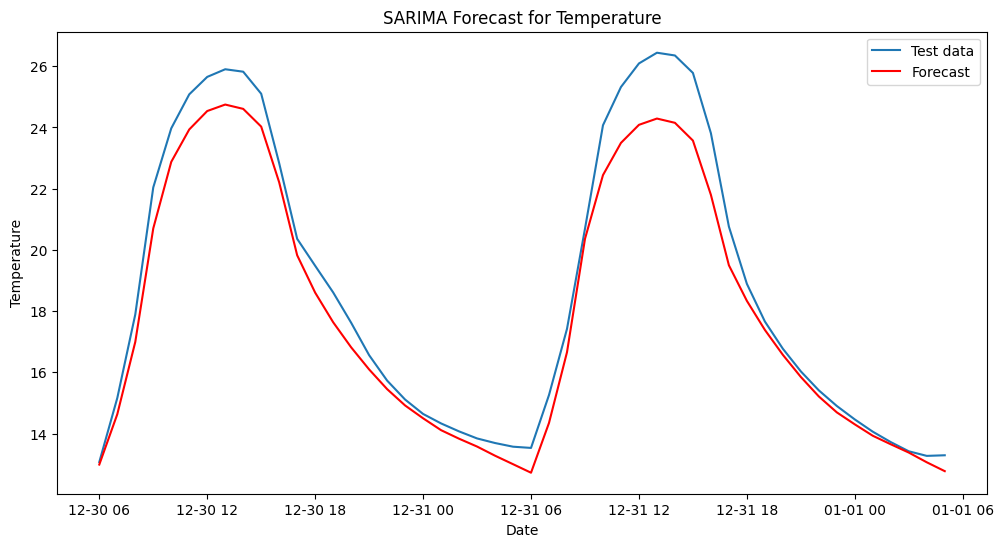

Root Mean Squared Error (RMSE): 0.9974564086473587
training now:  6


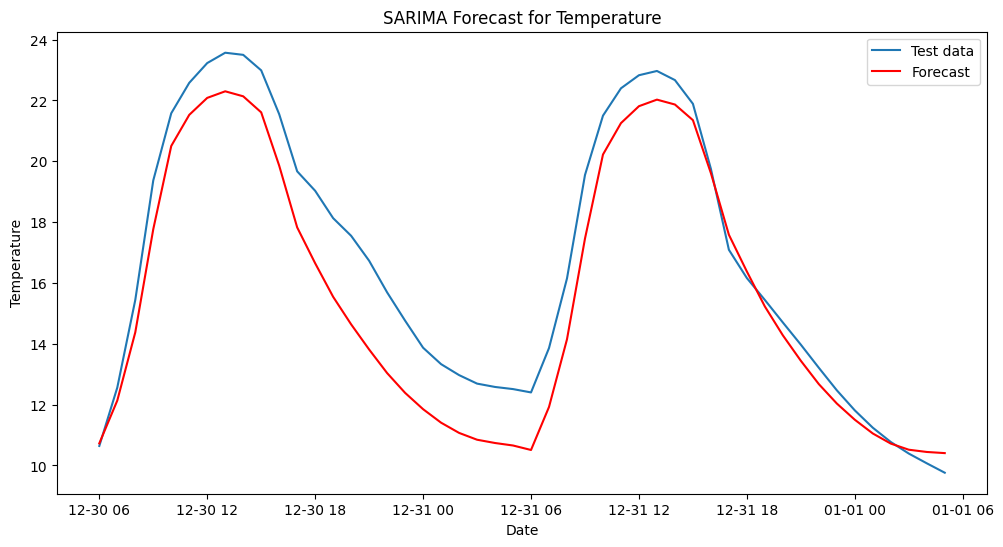

Root Mean Squared Error (RMSE): 1.4881209341461359
training now:  7


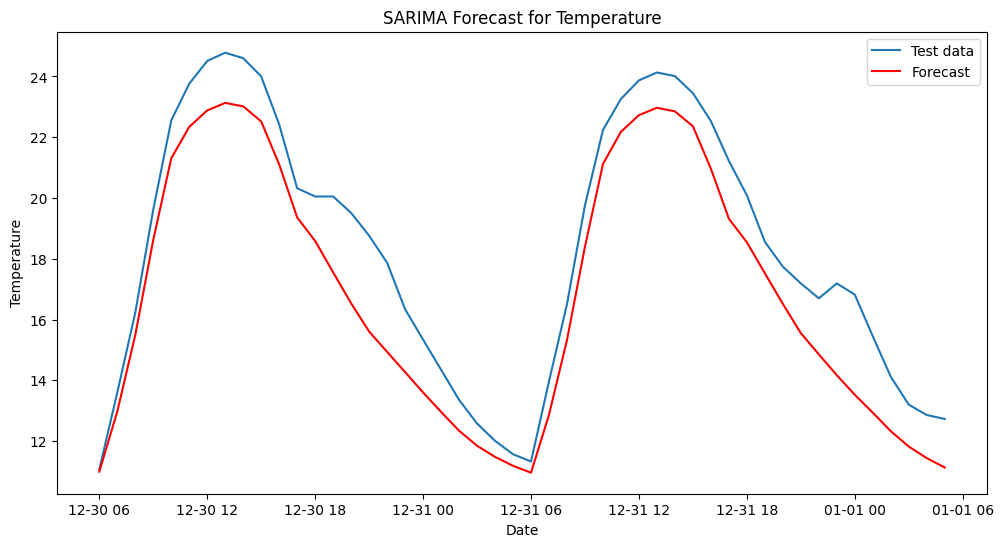

Root Mean Squared Error (RMSE): 1.6490580682880174
training now:  8


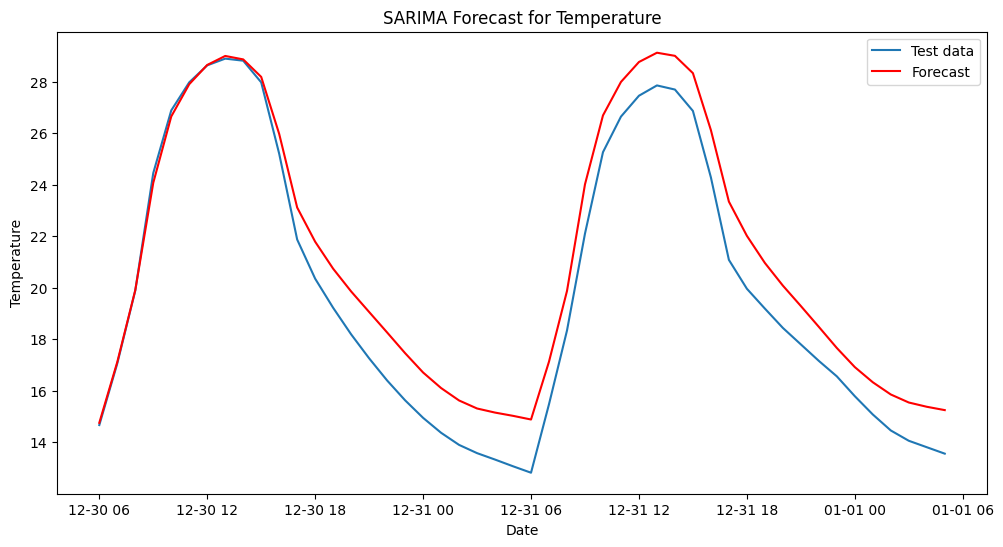

Root Mean Squared Error (RMSE): 1.4353201780902622
training now:  9


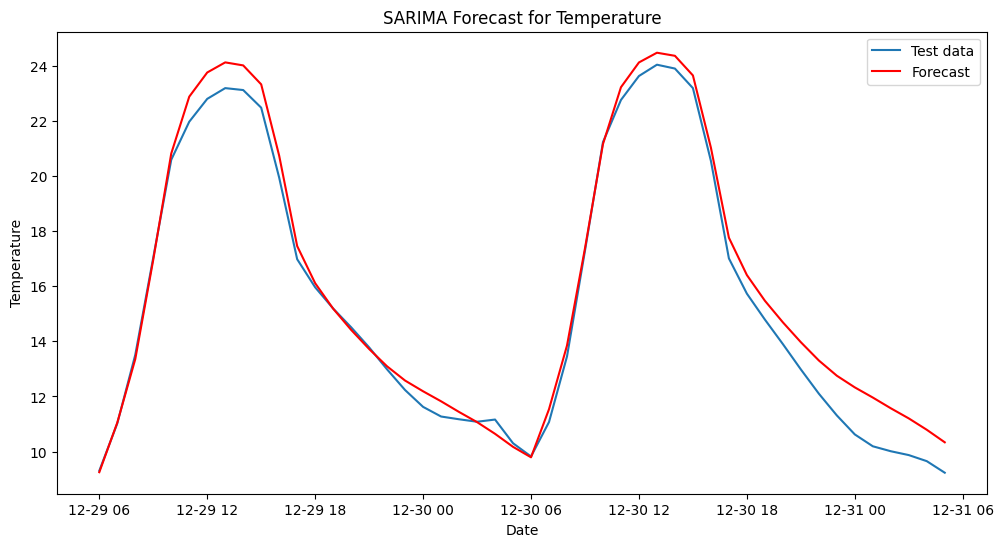

Root Mean Squared Error (RMSE): 0.7540080940343424
training now:  10


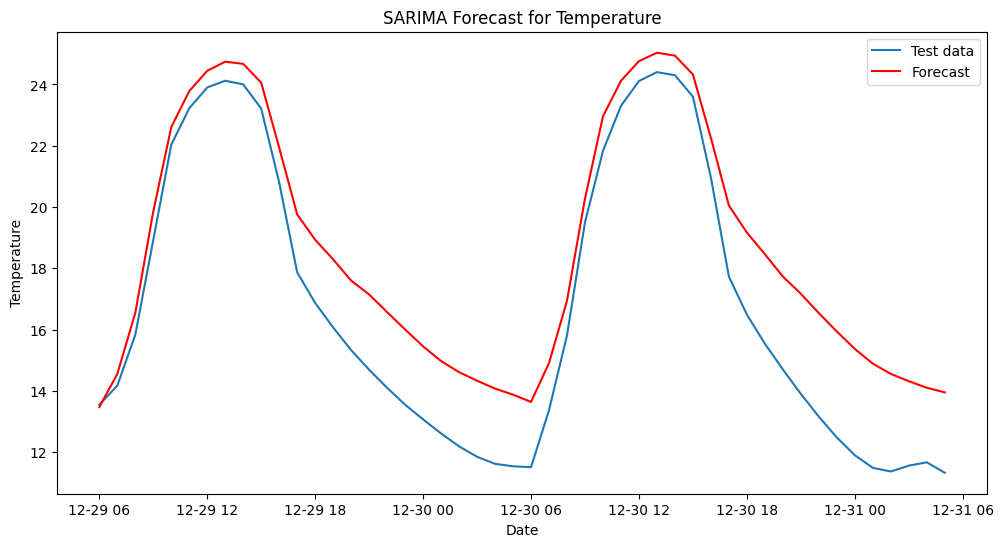

Root Mean Squared Error (RMSE): 2.0851057642815154
training now:  11


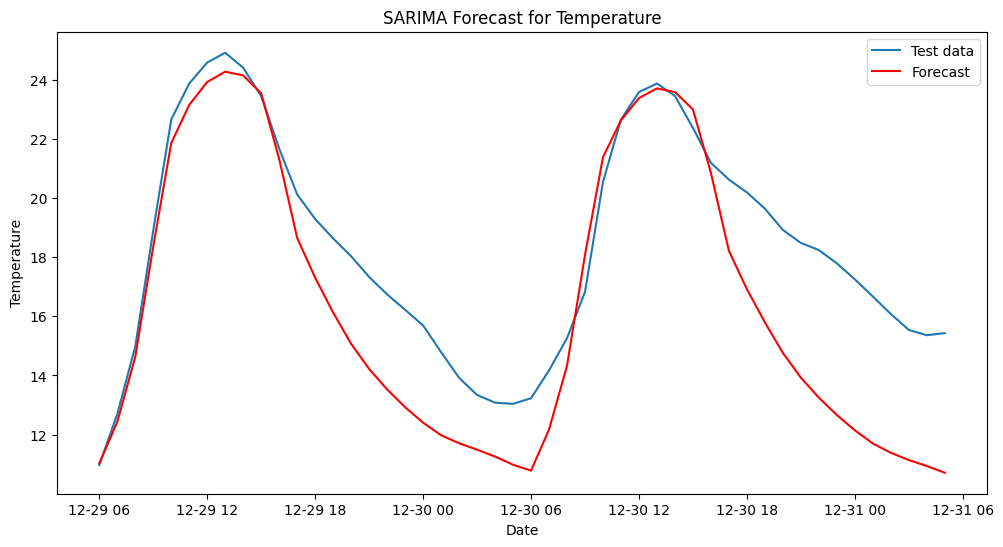

Root Mean Squared Error (RMSE): 2.7286873877583697
training now:  12


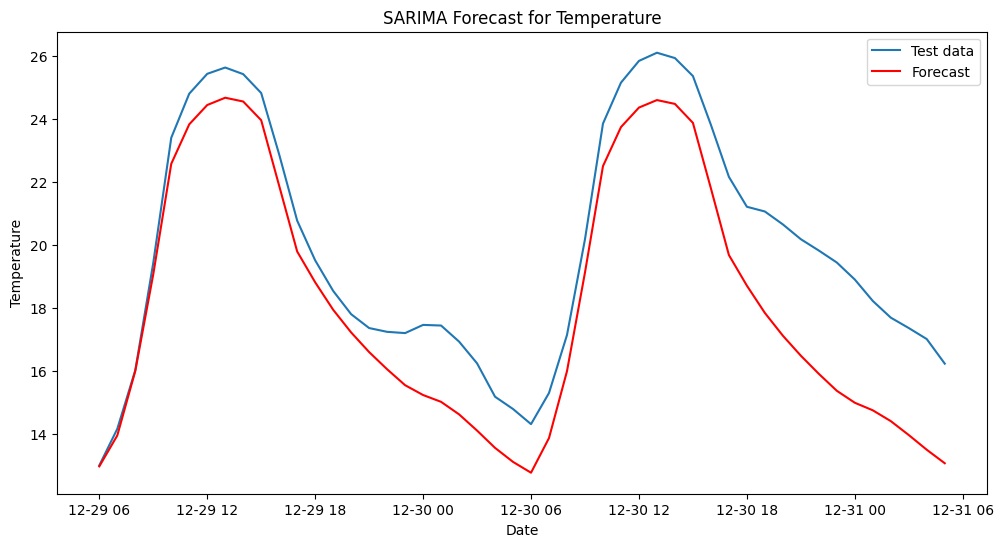

Root Mean Squared Error (RMSE): 2.119428728137174
training now:  13


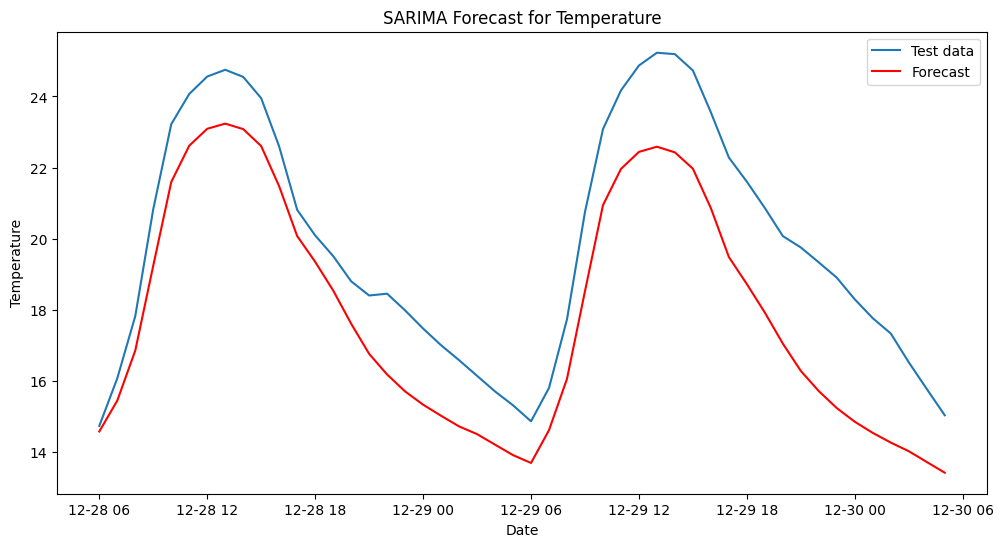

Root Mean Squared Error (RMSE): 2.172541628287326
training now:  14


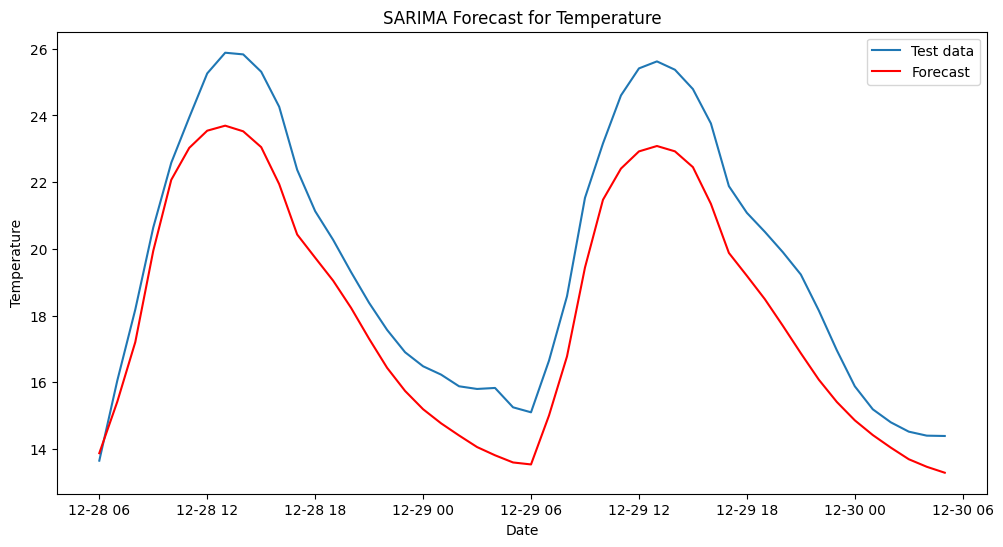

Root Mean Squared Error (RMSE): 1.6991434432000594
training now:  15


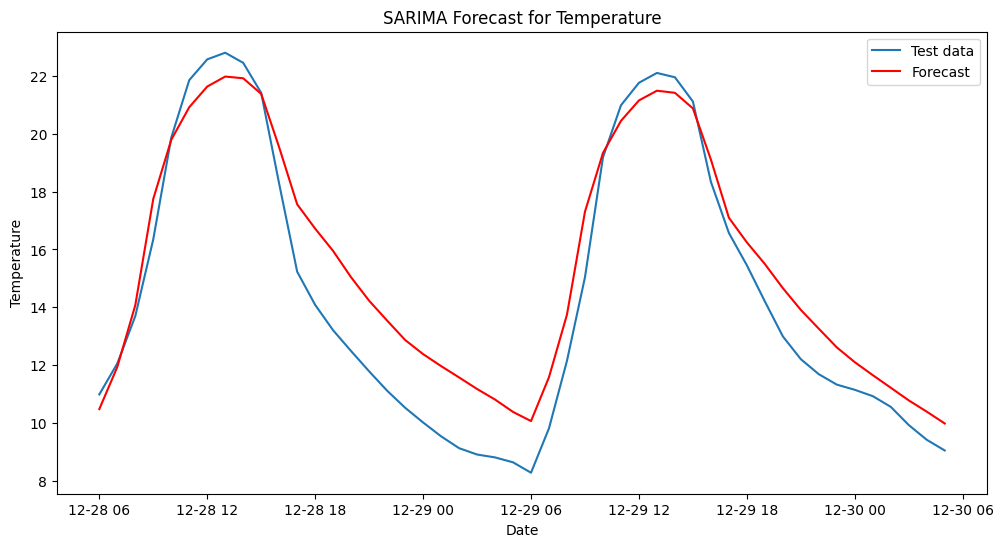

Root Mean Squared Error (RMSE): 1.5353898024596768
training now:  16


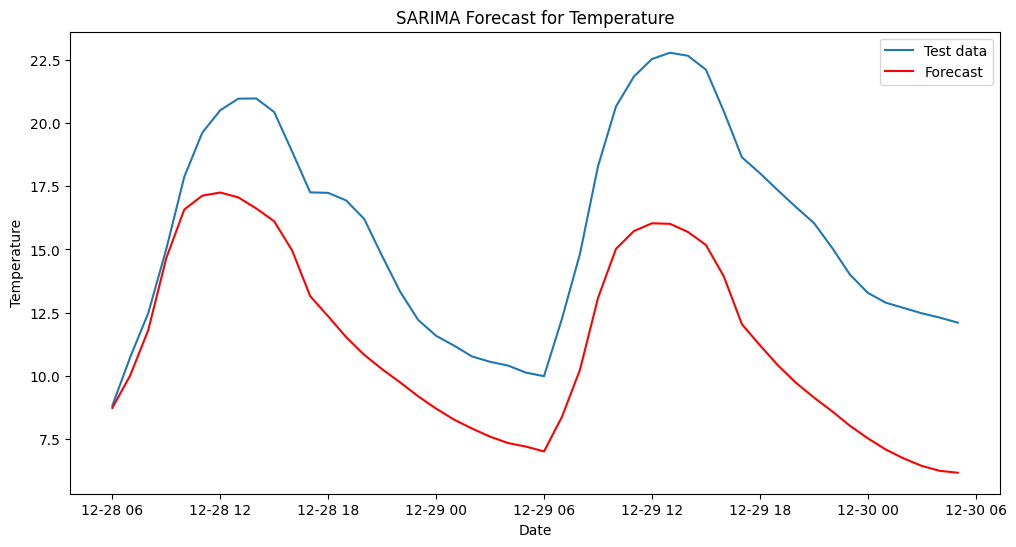

Root Mean Squared Error (RMSE): 4.944870737735417
training now:  17


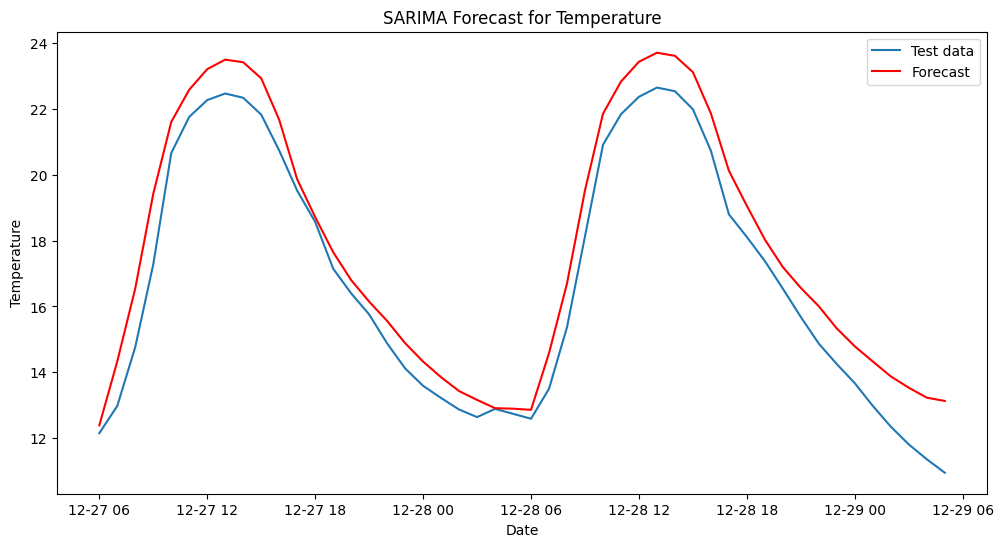

Root Mean Squared Error (RMSE): 1.0792710120960018
training now:  18


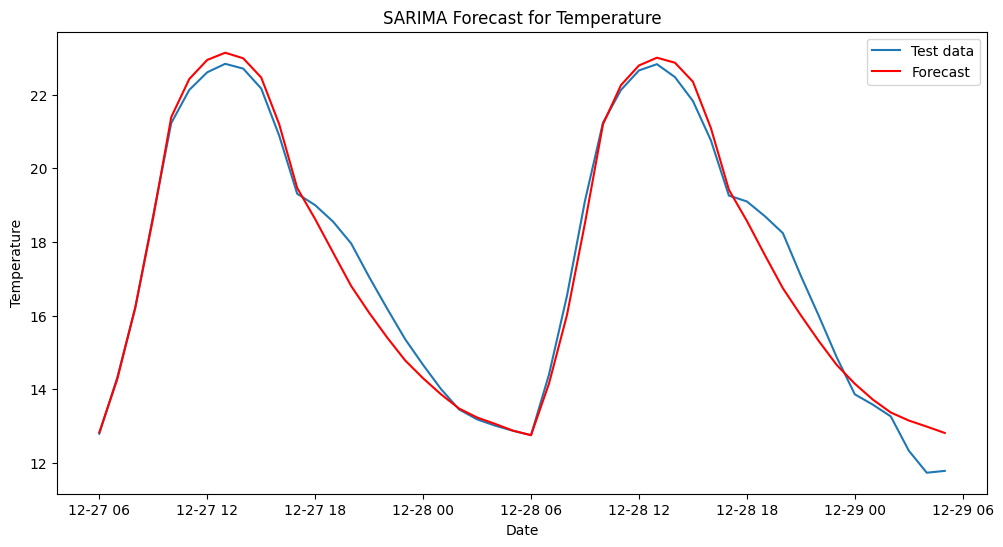

Root Mean Squared Error (RMSE): 0.5570813938442126
training now:  19


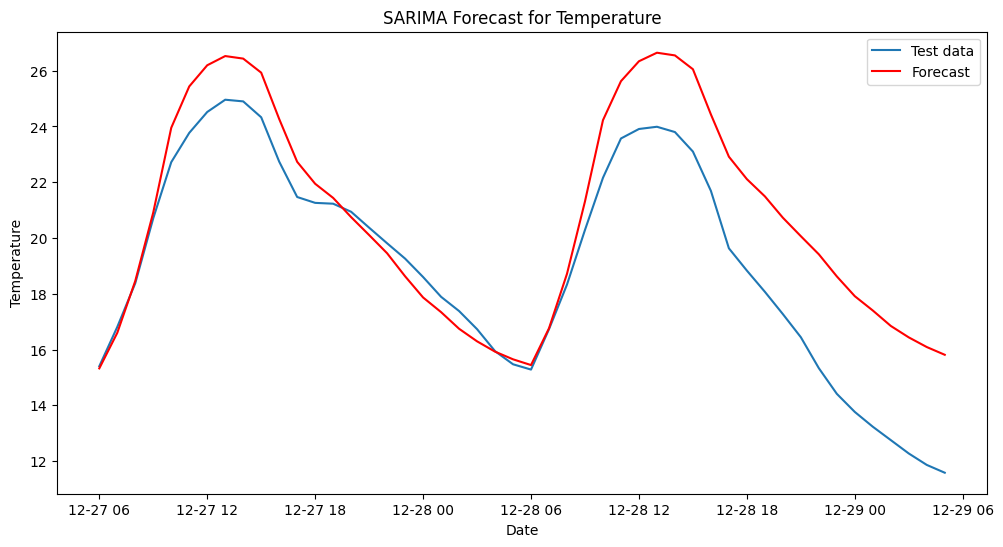

Root Mean Squared Error (RMSE): 2.3492706259266165
training now:  20


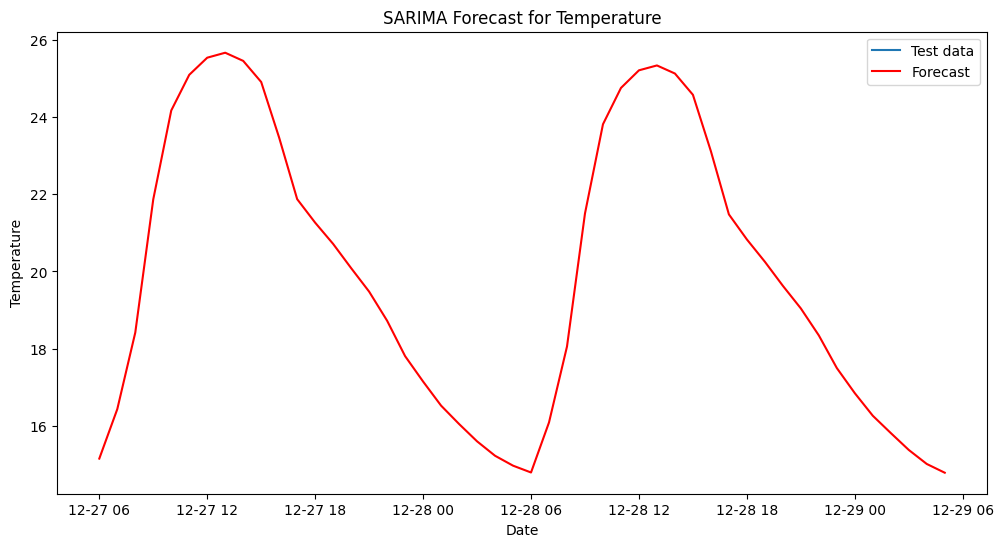

ValueError: Found input variables with inconsistent numbers of samples: [0, 48]

In [50]:
for i in range(2, 21):
    check2=train_data[table[i-2]:table[i-1]]
    test2=train_data[table[i-1]:table[i-1]+48] #2 days = 48 hours
    print("training now: ", i)
    #training
    agartala_result=agartala_result.extend(check2["TEMP"])
    #forecasting
    forecast2 = agartala_result.get_forecast(steps=48)
    # Plot the predicted values along with the actual values
    plt.figure(figsize=(12, 6))
    plt.plot(test2.index, test2["TEMP"], label='Test data')
    plt.plot(forecast2.predicted_mean, label='Forecast', color='red')
    plt.title('SARIMA Forecast for Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()
    #RMSE
    rmse = np.sqrt(mean_squared_error(test2["TEMP"], forecast2.predicted_mean))
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    # to store RMSE for every year
    rmse_record[i] = rmse

In [51]:
rmse_record

{1: 2.4306795473143294,
 2: 0.7123344503488975,
 3: 0.48892623968637655,
 4: 1.0297014559185809,
 5: 0.9974564086473587,
 6: 1.4881209341461359,
 7: 1.6490580682880174,
 8: 1.4353201780902622,
 9: 0.7540080940343424,
 10: 2.0851057642815154,
 11: 2.7286873877583697,
 12: 2.119428728137174,
 13: 2.172541628287326,
 14: 1.6991434432000594,
 15: 1.5353898024596768,
 16: 4.944870737735417,
 17: 1.0792710120960018,
 18: 0.5570813938442126,
 19: 2.3492706259266165}

In [52]:
#saving pickle file of model
with open("/kaggle/working/agartala_model.pkl", 'wb') as f:
    pickle.dump(agartala_result, f)